In [1]:
import nibabel as nb
import numpy as np
import os
import matplotlib.pyplot as plt
import imageio
from pathlib import Path
import glob
import cv2
import random
import fnmatch
from PIL import Image, ImageStat
import pandas as pd
from tqdm import tqdm
from scipy import ndimage
from sklearn.model_selection import train_test_split

import utils
# from IPython.core.interactiveshell import InteractiveShell
# InteractiveShell.ast_node_interactivity = "all"

In [2]:
files = glob.glob('../fundus_dataset/img_512/train/*')
len(files)

181271

In [3]:
files[:10]
pattern = '/media/tianyu.han/mri-scratch/DeepLearning/fundus_dataset/diabetic_dataset/test/27096_right.jpeg'
matching = fnmatch.filter(files, pattern)
print(matching)

[]


In [4]:
means, stds = [], []
for file in tqdm(files):
    img = imageio.imread(file)
    img = img / img.max()
    means.append(img.mean((0, 1)))
    stds.append(img.std((0, 1)))

 24%|██▍       | 43303/181271 [40:17<2:10:48, 17.58it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

100%|██████████| 181271/181271 [2:49:36<00:00, 17.81it/s]  


In [2]:
from torchvision import datasets, transforms

class DataAugmentationDINO(object):
    def __init__(self, global_crops_scale, local_crops_scale, local_crops_number):
        flip_and_color_jitter = transforms.Compose([
            transforms.RandomHorizontalFlip(p=0.5),
            transforms.RandomApply(
                [transforms.ColorJitter(brightness=0.4, contrast=0.4, saturation=0.2, hue=0.1)],
                p=0.8
            ),
            transforms.RandomGrayscale(p=0.2),
        ])
        normalize = transforms.Compose([
            transforms.ToTensor(),
            # transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
            # transforms.Normalize((0.5, 0.5, 0.5), (0.25, 0.25, 0.25)),
        ])

        # first global crop
        self.global_transfo1 = transforms.Compose([
            transforms.RandomResizedCrop(224, scale=global_crops_scale, interpolation=Image.BICUBIC),
            flip_and_color_jitter,
            utils.GaussianBlur(1.0),
            normalize,
        ])
        # second global crop
        self.global_transfo2 = transforms.Compose([
            transforms.RandomResizedCrop(224, scale=global_crops_scale, interpolation=Image.BICUBIC),
            flip_and_color_jitter,
            utils.GaussianBlur(0.1),
            utils.Solarization(0.2),
            normalize,
        ])
        # transformation for the local small crops
        self.local_crops_number = local_crops_number
        self.local_transfo = transforms.Compose([
            transforms.RandomResizedCrop(96, scale=local_crops_scale, interpolation=Image.BICUBIC),
            flip_and_color_jitter,
            utils.GaussianBlur(p=0.5),
            normalize,
        ])

    def __call__(self, image):
        crops = []
        crops.append(self.global_transfo1(image))
        crops.append(self.global_transfo2(image))
        for _ in range(self.local_crops_number):
            crops.append(self.local_transfo(image))
        return crops

In [3]:
DEL_PADDING_RATIO = 0.02  #used for del_black_or_white
CROP_PADDING_RATIO = 0.0  #used for my_crop_xyr

# del_black_or_white margin
THRETHOLD_LOW = 7
THRETHOLD_HIGH = 180

# HoughCircles
MIN_REDIUS_RATIO = 0.33
MAX_REDIUS_RATIO = 0.6


def detect_xyr(img_source):
    if isinstance(img_source, str):
        try:
            img = imageio.imread(img_source)
        except:
            # Corrupt JPEG data1: 19 extraneous bytes before marker 0xc4
            raise Exception("image file not found:" + img_source)
        if img is None:
            raise Exception("image file error:" + img_source)
    else:
        img = img_source


    width = img.shape[1]
    height = img.shape[0]

    myMinWidthHeight = min(width, height)  

    myMinRadius = round(myMinWidthHeight * MIN_REDIUS_RATIO)
    myMaxRadius = round(myMinWidthHeight * MAX_REDIUS_RATIO)

    '''
    parameters of HoughCircles
    According to our test about fundus images, param2 = 30 is enough, too high will miss some circles
    '''

    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    circles = cv2.HoughCircles(gray, cv2.HOUGH_GRADIENT, 1, minDist=450, param1=120, param2=32,
                               minRadius=myMinRadius,
                               maxRadius=myMaxRadius)

    (x, y, r) = (0, 0, 0)
    found_circle = False

    if circles is not None:
        circles = np.round(circles[0, :]).astype("int")
        if (circles is not None) and (len(circles == 1)):
            # x width, y height

            x1, y1, r1 = circles[0]
            if x1 > (2 / 5 * width) and x1 < (3 / 5 * width) \
                    and y1 > (2 / 5 * height) and y1 < (3 / 5 * height):
                x, y, r = circles[0]
                found_circle = True

    if not found_circle:
        # suppose the center of the image is the center of the circle.
        x = img.shape[1] // 2
        y = img.shape[0] // 2

        # get radius  according to the distribution of pixels of the middle line
        temp_x = img[int(img.shape[0] / 2), :, :].sum(1)
        r = int((temp_x > temp_x.mean() / 12).sum() / 2)
    
    return (found_circle, x, y, r)

def my_crop_xyr(img_source, x, y, r, crop_size=None, mode='symmetric'):
    if isinstance(img_source, str):
        # img_source is a file name
        try:
            image1 = imageio.imread(img_source)
        except:
            # Corrupt JPEG data1: 19 extraneous bytes before marker 0xc4
            raise Exception("image file not found:" + img_source)
    else:
        image1 = img_source

    if image1 is None:
        raise Exception("image file error:" + img_source)

    original_width = image1.shape[1]
    original_height = image1.shape[0]

    (image_height, image_width) = (image1.shape[0], image1.shape[1])

    img_padding = int(min(original_width, original_height) * CROP_PADDING_RATIO)

    image_left = int(max(0, x - r - img_padding))
    image_right = int(min(x + r + img_padding, image_width - 1))
    image_bottom = int(max(0, y - r - img_padding))
    image_top = int(min(y + r + img_padding, image_height - 1))

    if image_width >= image_height: 
        if image_height >= 2 * (r + img_padding):
            image1 = image1[image_bottom: image_top, image_left:image_right]
        else:
            image1 = image1[:, image_left:image_right]
    else:  
        if image_width >= 2 * (r + img_padding):
            image1 = image1[image_bottom: image_top, image_left:image_right]
        else:
            image1 = image1[image_bottom:image_top, :]

    if crop_size is not None:
        if image1.shape[0] > image1.shape[1]:
            # pad along axis 1 
            width = (image1.shape[0] - image1.shape[1]) // 2
            image1 = np.pad(image1, pad_width=((0, 0), (width, width), (0, 0)), mode=mode)
        else:
            width = (image1.shape[1] - image1.shape[0]) // 2
            image1 = np.pad(image1, pad_width=((width, width), (0, 0), (0, 0)), mode=mode)
        image1 = cv2.resize(image1, (crop_size, crop_size))

    return image1



def get_fundus(img_source, crop_size, mode='symmetric'):
    if isinstance(img_source, str):
        try:
            image1 = imageio.imread(img_source)
        except:
            # Corrupt JPEG data1: 19 extraneous bytes before marker 0xc4
            raise Exception("image file not found:" + img_source)
    else:
        image1 = img_source

    if image1 is None:  #file not exists or orther errors
        raise Exception("image file error:" + img_source)

    min_width_height = min(image1.shape[0], image1.shape[1])

    if min_width_height < 100: # image too small
        return None

    #image too big, resize
    image_size_before_hough = crop_size * 2
    if min_width_height > image_size_before_hough:
        # crop_ratio = image_size_before_hough / min_width_height
        crop_ratiox = image_size_before_hough / image1.shape[0]
        crop_ratioy = image_size_before_hough / image1.shape[1]
        # image1 = cv2.resize(image1, None, fx=crop_ratiox, fy=crop_ratioy)

    (found_circle, x, y, r) = detect_xyr(image1)
    image1 = my_crop_xyr(image1, x, y, r, crop_size, mode)
    img = (image1 - image1.min()) / (image1.max() - image1.min())
    # img = np.clip(np.rint(img * 255.0), 0.0, 255.0)

    return img # with range [0, 1]

In [9]:
from PIL import Image
import pandas as pd
import numpy as np

from torch.utils.data import Dataset
# from dataset.utils import get_fundus

class PatchDataset(Dataset):
    def __init__(self, fold, sample=0, transform=None):

        self.transform = transform
        # self.path_to_images = path_to_images
        self.df = pd.read_csv("./csv/split.csv")
        self.fold = fold
        self.df = self.df[self.df['fold'] == fold]
        if(sample > 0 and sample < len(self.df)):
            self.df = self.df.sample(frac=sample, random_state=42)
            print('subsample the training set with ratio %f' % sample)
        self.files = self.df['path']

    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx):
        img_path = self.files[idx]
        image = get_fundus(img_path, crop_size=512, mode='constant')
        # image = (image - image.min()) / (image.max() - image.min())
        image = np.clip(np.rint(image * 255.0), 0.0, 255.0).astype(np.uint8)
        _ = plt.imshow(image)
        _ = plt.show()
        
        image = Image.fromarray(image)
        print(ImageStat.Stat(image))
        if self.transform:
            out = self.transform(image)

        return out

transform = DataAugmentationDINO(
        (0.8, 1),
        (0.2, 0.4),
        2)
pdataset = PatchDataset(fold='train', transform=transform)

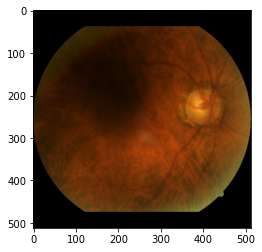

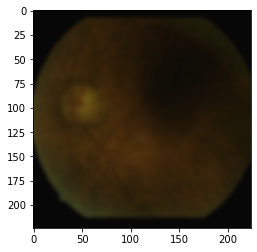

tensor(0.1003)


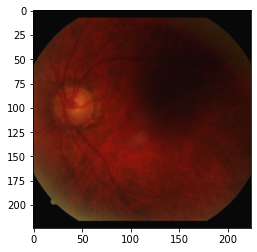

tensor(0.1339)


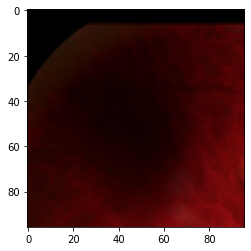

tensor(0.0722)


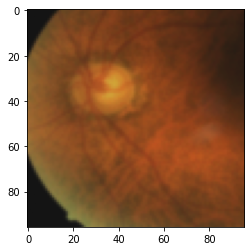

tensor(0.2900)


In [10]:
outs = pdataset[100]
for out in outs:
    _ = plt.imshow(np.array(out.moveaxis(0, -1)))
    _ = plt.show()
    print(out.mean())

In [19]:
df = pd.read_csv("./csv/split.csv")
df = df[df['fold'] == 'train']
files = df['path'].tolist()
means = []
for file in tqdm(files):
    image = get_fundus(file, crop_size=512, mode='constant')
    means.append(image.mean((0, 1)))

  0%|          | 63/181272 [00:39<31:11:29,  1.61it/s]


KeyboardInterrupt: 